In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from lib.feature_extractor import extraction_model as em
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from externals.d2net.lib import localization, utils
from lib import autoencoder, attention_model
from PIL import Image
import matplotlib.pyplot as plt
import torchvision as tv
from lib import correspondence_datamodule
from skimage.feature import match_descriptors
from skimage.measure import ransac
from skimage.transform import ProjectiveTransform
import cv2

In [3]:
class DummyEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = tv.models.resnet50(pretrained=True)
        self.extractor = correspondence_datamodule.ResnetActivationExtractor(self.model)
        self.encoded_channels=1024
    
    def forward(self, image):
        a = self.extractor(image)
        return {
            'early': a['layer3_conv3'],
            'middle': a['layer3_conv3'],
            'deep': a['layer3_conv3'],
        }

torch.Size([626])


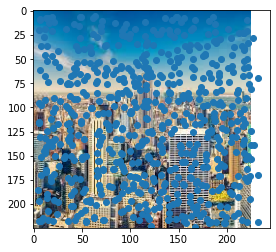

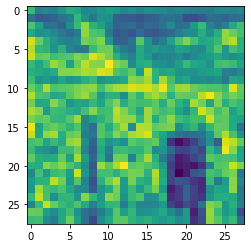

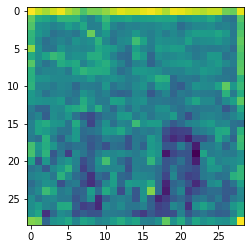

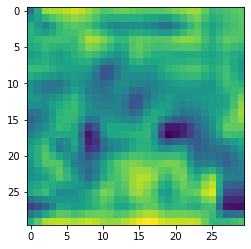

In [4]:
encoder = autoencoder.FeatureEncoder1.load_from_checkpoint('/home/mark/eth/enc.ckpt', load_tf_weights=False).eval()

#encoder = DummyEncoder().eval()
#attention = attention_model.MultiAttentionLayer(encoder).eval()
attention = attention_model.MultiAttentionLayer.load_from_checkpoint('/home/mark/eth/attent.ckpt', feature_encoder=encoder).eval()

extraction_model = em.ExtractionModel(attention, use_d2net_detection=False, num_upsampling=3)
image = Image.open('/home/mark/Downloads/test.jpg')
image_np = np.array(image)
image = utils.preprocess_image(image_np)
image = torch.as_tensor(image)
image = torch.unsqueeze(image, 0)

keypoints, descriptors, scores, detections = extraction_model(image)

print(scores.size())

plt.imshow(image_np)
plt.scatter(keypoints[:, 0], keypoints[:, 1])
plt.show()
plt.imshow(detections[0])
plt.show()
plt.imshow(detections[1])
plt.show()
plt.imshow(detections[2])

In [5]:
pair_idx = 1
assert(pair_idx in [1, 2, 3])
pair_path = os.path.join('qualitative/images', f'pair_{pair_idx}')

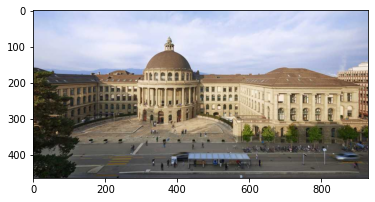

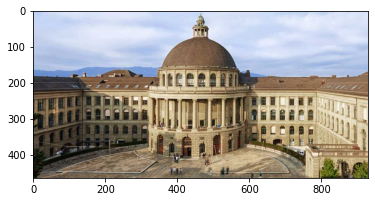

In [6]:
img = Image.open(os.path.join(pair_path, '1.jpg'))
#img = img.resize([img.size[0]*2, img.size[1]*2])
image1_np = np.array(img)
img = Image.open(os.path.join(pair_path, '2.jpg'))
#img = img.resize([img.size[0]*2, img.size[1]*2])
image2_np = np.array(img)
image1 = utils.preprocess_image(image1_np)
image1 = torch.as_tensor(image1)
image1 = torch.unsqueeze(image1, 0)
image2 = utils.preprocess_image(image2_np)
image2 = torch.as_tensor(image2)
image2 = torch.unsqueeze(image2, 0)

plt.imshow(image1_np)
plt.show()
plt.imshow(image2_np)
plt.show()

In [7]:
# encoder = DummyEncoder().eval()
# attention = attention_model.MultiAttentionLayer(encoder).eval()

# extraction_model = em.ExtractionModel(attention, use_d2net_detection=False, num_upsampling=4, thresh=0.0)
encoder = autoencoder.FeatureEncoder1.load_from_checkpoint('/home/mark/eth/enc.ckpt', load_tf_weights=False).eval()

#encoder = DummyEncoder().eval()
#attention = attention_model.MultiAttentionLayer(encoder).eval()
attention = attention_model.MultiAttentionLayer.load_from_checkpoint('/home/mark/eth/attent.ckpt', feature_encoder=encoder).eval()

extraction_model = em.ExtractionModel(attention, use_d2net_detection=False, num_upsampling=3, thresh=0.15)

In [8]:
kp1, descr1, scores1, det1 = extraction_model(image1)
kp2, descr2, scores2, det2 = extraction_model(image2)

# For dummy encoder, we get 3 times the same output
s1 = scores1.size()[0] #// 3
print(f'{scores1.size()[0]} --> {s1}')
kp1 = kp1[:s1, :].numpy()
descr1 = descr1[:s1, :].numpy()
scores1 = scores1[:s1]

s2 = scores2.size()[0] #// 3
print(f'{scores2.size()[0]} --> {s2}')
kp2 = kp2[:s2, :].numpy()
descr2 = descr2[:s2, :].numpy()
scores2 = scores2[:s2]

print(scores1)
print(scores2)

5415 --> 5415
5239 --> 5239
tensor([0.2507, 0.2460, 0.2450,  ..., 0.1500, 0.1500, 0.1500])
tensor([0.2462, 0.2425, 0.2416,  ..., 0.1501, 0.1501, 0.1500])


In [9]:
matches = match_descriptors(descr1, descr2, cross_check=True)
n_matches = len(matches)
print(len(matches))

/home/mark/.local/lib/python3.8/site-packages/skimage/feature/match.py:57: FutureWarning: Conversion of the second argument of issubdtype from `bool` to `np.generic` is deprecated. In future, it will be treated as `np.bool_ == np.dtype(bool).type`.
  if np.issubdtype(descriptors1.dtype, bool):


55


In [10]:
keypoints_left = kp1[matches[:, 0], : 2]
keypoints_right = kp2[matches[:, 1], : 2]
print(keypoints_left)
np.random.seed(0)
model, inliers = ransac(
    (keypoints_left, keypoints_right),
    ProjectiveTransform, min_samples=4,
    residual_threshold=4, max_trials=10000
)
n_inliers = np.sum(inliers)
print('Number of inliers: %d.' % n_inliers)

[[ 28.461115    7.0532823]
 [547.8119    432.88733  ]
 [479.71677    75.132484 ]
 [841.6864    384.89066  ]
 [765.28046   410.9901   ]
 [428.68015   282.50293  ]
 [307.75388   308.73993  ]
 [277.68698   209.93819  ]
 [153.54553   463.7679   ]
 [209.39996   208.50732  ]
 [757.98096   124.72507  ]
 [419.84573    19.43843  ]
 [117.4313    316.7401   ]
 [418.58078   380.24695  ]
 [716.25684   107.673775 ]
 [515.05743   325.03485  ]
 [ 17.082354  264.3807   ]
 [731.3684    458.77957  ]
 [ 18.063236  262.5996   ]
 [149.72653   210.48975  ]
 [337.9385    258.8695   ]
 [611.532     236.81764  ]
 [184.49052   295.14993  ]
 [696.33325   206.6433   ]
 [ 49.73629    37.799267 ]
 [218.34567   413.9442   ]
 [717.2391     69.4513   ]
 [ 58.102604  171.16003  ]
 [616.3059     39.007877 ]
 [602.7766    258.84723  ]
 [381.2916    427.18637  ]
 [441.47617   394.2062   ]
 [243.62065   222.7258   ]
 [589.73303   210.50352  ]
 [684.44556   410.77612  ]
 [258.56116   441.19742  ]
 [322.70407   285.9063   ]
 

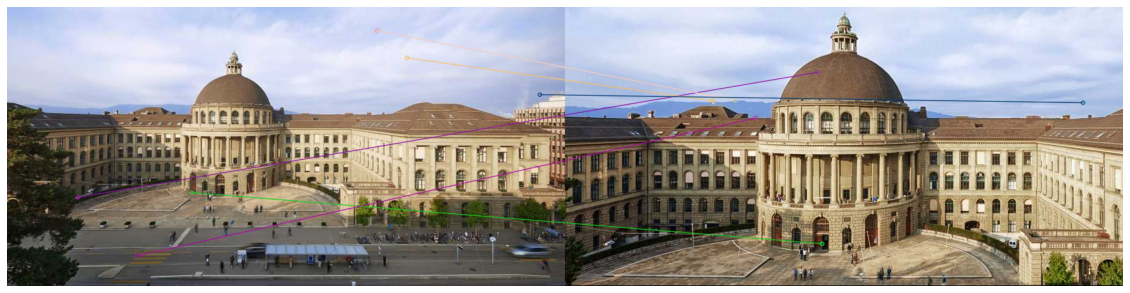

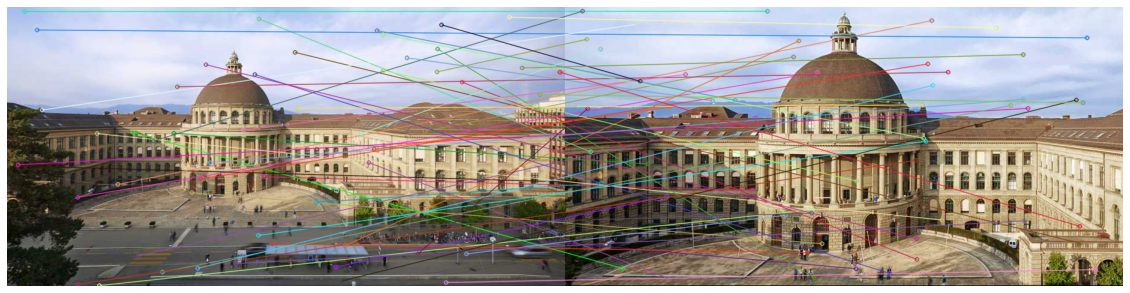

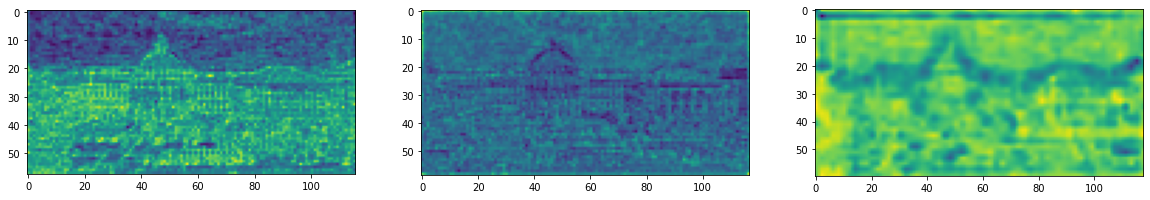

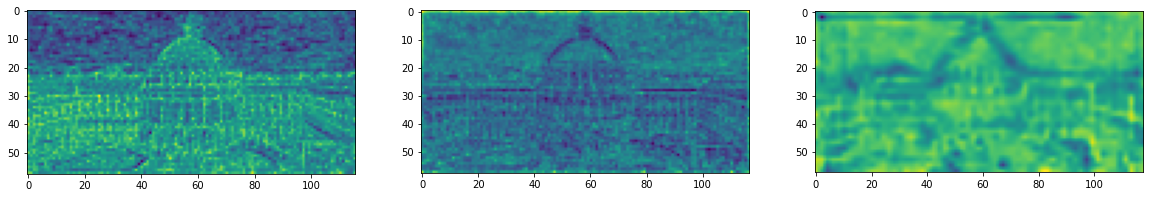

[array([[0.16730377, 0.15664375, 0.15354416, ..., 0.15290824, 0.15257537,
        0.15074192],
       [0.15989786, 0.16056122, 0.15513128, ..., 0.14940065, 0.153344  ,
        0.15401547],
       [0.15496407, 0.15070488, 0.16017973, ..., 0.15846571, 0.15687868,
        0.15575542],
       ...,
       [0.18946934, 0.18260516, 0.18623225, ..., 0.16750483, 0.16726236,
        0.16959612],
       [0.18132953, 0.17188269, 0.18872826, ..., 0.16590495, 0.1617485 ,
        0.17297731],
       [0.19452941, 0.19330299, 0.1740862 , ..., 0.16311194, 0.16277921,
        0.18854412]], dtype=float32), array([[0.259091  , 0.24005769, 0.23266746, ..., 0.22772463, 0.23161304,
        0.2572993 ],
       [0.21951483, 0.20526466, 0.19979385, ..., 0.1808441 , 0.18085304,
        0.21414475],
       [0.21885432, 0.18820965, 0.20564023, ..., 0.18207084, 0.17241578,
        0.21644068],
       ...,
       [0.17388137, 0.16761313, 0.17001523, ..., 0.19300358, 0.17703743,
        0.18702027],
       [0.17445944

In [11]:
inlier_keypoints_left = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_left[inliers]]
inlier_keypoints_right = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_right[inliers]]
placeholder_matches = [cv2.DMatch(idx, idx, 1) for idx in range(n_inliers)]
image3 = cv2.drawMatches(image1_np, inlier_keypoints_left, image2_np, inlier_keypoints_right, placeholder_matches, None)

plt.figure(figsize=(20, 20))
plt.imshow(image3)
plt.axis('off')
plt.show()

inlier_keypoints_left = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_left]
inlier_keypoints_right = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_right]
placeholder_matches = [cv2.DMatch(idx, idx, 1) for idx in range(n_matches)]
image4 = cv2.drawMatches(image1_np, inlier_keypoints_left, image2_np, inlier_keypoints_right, placeholder_matches, None)

plt.figure(figsize=(20, 20))
plt.imshow(image4)
plt.axis('off')
plt.show()

fig, axs = plt.subplots(1,3, figsize=(20, 20))
axs[0].imshow(det1[0])
axs[1].imshow(det1[1])
axs[2].imshow(det1[2])
plt.show()

fig, axs = plt.subplots(1,3, figsize=(20, 20))
axs[0].imshow(det2[0])
axs[1].imshow(det2[1])
axs[2].imshow(det2[2])
plt.show()
print(det2[:])